# Apple MobileCLIP Evaluation: retrieval metrics

This notebook loads the best Apple MobileCLIP checkpoint, computes image and text embeddings on the validation set,
and reports retrieval metrics (Top-1, Top-5, Top-10).

Ensure you run this from the repository root so relative paths match (or update the paths below).

In [1]:
# Configuration
from pathlib import Path
import sys
repo_root = Path('..').resolve()  # adjust if running from a different CWD
sys.path.append(str(repo_root))

CHECKPOINT_PATH = Path('checkpoints/best_clipp_apple.pth')
VAL_CSV = Path('../../data/alpaca_mbj_bandgap_test.csv')
BATCH_SIZE = 32
DEVICE = 'cuda' if __import__('torch').cuda.is_available() else 'cpu'
print(f'Using device: {DEVICE}, checkpoint: {CHECKPOINT_PATH}')

Using device: cuda, checkpoint: checkpoints/best_clipp_apple.pth


In [ ]:
# Setup matplotlib for Jupyter notebook
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Set matplotlib backend
matplotlib.use('Agg')  # Use Anti-Grain Geometry backend
plt.ioff()  # Turn off interactive mode

print("Matplotlib setup complete")

In [2]:
repo_root

PosixPath('/home/jipengsun/MaterialVision/models')

In [4]:
# Imports and model/dataset loading
import torch
import pandas as pd
import open_clip
from torch.utils.data import DataLoader

# Import CLIPP and ImageTextDataset from the training script
from training import AppleCLIPP, ImageTextDataset

# Load MobileCLIP-S2 tokenizer and preprocessor
model_s2, _, preprocess_s2 = open_clip.create_model_and_transforms('MobileCLIP-S2', pretrained='datacompdr')
tokenizer_s2 = open_clip.get_tokenizer('MobileCLIP-S2')

# Initialize model
model = AppleCLIPP(proj_dim=256)
device = torch.device(DEVICE)

# Load checkpoint
assert CHECKPOINT_PATH.exists(), f"Checkpoint not found: {CHECKPOINT_PATH}"
ckpt = torch.load(str(CHECKPOINT_PATH), map_location=device)
model.load_state_dict(ckpt['model_state_dict'])
model.to(device)
model.eval()

# Load validation data
val_df = pd.read_csv(VAL_CSV)
val_ds = ImageTextDataset(val_df, tokenizer_s2, preprocess_s2, train=False)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
print(f'Validation examples: {len(val_ds)}')

2025-11-08 23:17:06,841 INFO: Loaded MobileCLIP-S2 model config.
2025-11-08 23:17:09,423 INFO: Loading pretrained MobileCLIP-S2 weights (datacompdr).
2025-11-08 23:17:10,014 INFO: Loaded MobileCLIP-S2 model config.
2025-11-08 23:17:12,545 INFO: Loading pretrained MobileCLIP-S2 weights (datacompdr).


Validation examples: 1000


In [5]:
# Compute embeddings for entire validation set
import torch
val_img_embs_list = []
val_txt_embs_list = []
captions = []

with torch.no_grad():
    for batch in val_loader:
        images = batch['image'].to(device)
        text_tokens = batch['text_tokens'].to(device)
        txts = batch['caption']
        
        img_e, txt_e = model(images, text_tokens)
        val_img_embs_list.append(img_e.cpu())
        val_txt_embs_list.append(txt_e.cpu())
        captions.extend(txts)

val_img_embs = torch.cat(val_img_embs_list, dim=0)
val_txt_embs = torch.cat(val_txt_embs_list, dim=0)
print(f'Computed validation embeddings: images {val_img_embs.shape}, texts {val_txt_embs.shape}')

Computed validation embeddings: images torch.Size([1000, 256]), texts torch.Size([1000, 256])


In [ ]:
# Function to compute both text-to-image and image-to-text retrieval accuracies
import torch

def compute_retrieval_metrics(text_embeddings, image_embeddings, k_values=[1, 5, 10]):
    """
    Compute both text-to-image and image-to-text retrieval accuracies.
    
    Args:
        text_embeddings: tensor of shape (N, D) - text embeddings
        image_embeddings: tensor of shape (N, D) - image embeddings  
        k_values: list of k values for top-k accuracy
    
    Returns:
        similarity matrix for further analysis
    """
    # Compute similarity matrix
    scores = text_embeddings @ image_embeddings.T  # (N_text, N_image)
    
    # Text-to-Image Retrieval (text queries retrieving images)
    print("=== TEXT-TO-IMAGE RETRIEVAL ===")
    print("For each text query, find the correct corresponding image")
    
    for k in k_values:
        if k == 1:
            # Top-1: check if argmax equals correct index
            top_k_acc = torch.mean(
                (torch.argmax(scores, dim=1) == torch.arange(scores.shape[0], device=scores.device)).float()
            ).item()
        else:
            # Top-k: check if correct index is in top-k
            top_k_acc = torch.mean(
                torch.tensor([
                    i in torch.topk(scores[i], k).indices.tolist()
                    for i in range(scores.shape[0])
                ], dtype=torch.float32, device=scores.device)
            ).item()
        
        print(f"Text-to-Image Top-{k}: {top_k_acc:.4f}")
    
    # Image-to-Text Retrieval (image queries retrieving texts)  
    print("\n=== IMAGE-TO-TEXT RETRIEVAL ===")
    print("For each image query, find the correct corresponding text")
    
    scores_transposed = scores.T  # (N_image, N_text) - now images are queries
    
    for k in k_values:
        if k == 1:
            # Top-1: check if argmax equals correct index
            top_k_acc = torch.mean(
                (torch.argmax(scores_transposed, dim=1) == torch.arange(scores_transposed.shape[0], device=scores_transposed.device)).float()
            ).item()
        else:
            # Top-k: check if correct index is in top-k
            top_k_acc = torch.mean(
                torch.tensor([
                    i in torch.topk(scores_transposed[i], k).indices.tolist()
                    for i in range(scores_transposed.shape[0])
                ], dtype=torch.float32, device=scores_transposed.device)
            ).item()
        
        print(f"Image-to-Text Top-{k}: {top_k_acc:.4f}")
    
    return scores

# Compute retrieval metrics for validation set
print("VALIDATION SET RESULTS:") 
scores = compute_retrieval_metrics(val_txt_embs, val_img_embs)

VALIDATION SET RESULTS:
=== TEXT-TO-IMAGE RETRIEVAL ===
For each text query, find the correct corresponding image
Text-to-Image Top-1: 0.3800
Text-to-Image Top-5: 0.6700
Text-to-Image Top-10: 0.7670

=== IMAGE-TO-TEXT RETRIEVAL ===
For each image query, find the correct corresponding text
Image-to-Text Top-1: 0.3590
Image-to-Text Top-5: 0.6540
Image-to-Text Top-10: 0.7760


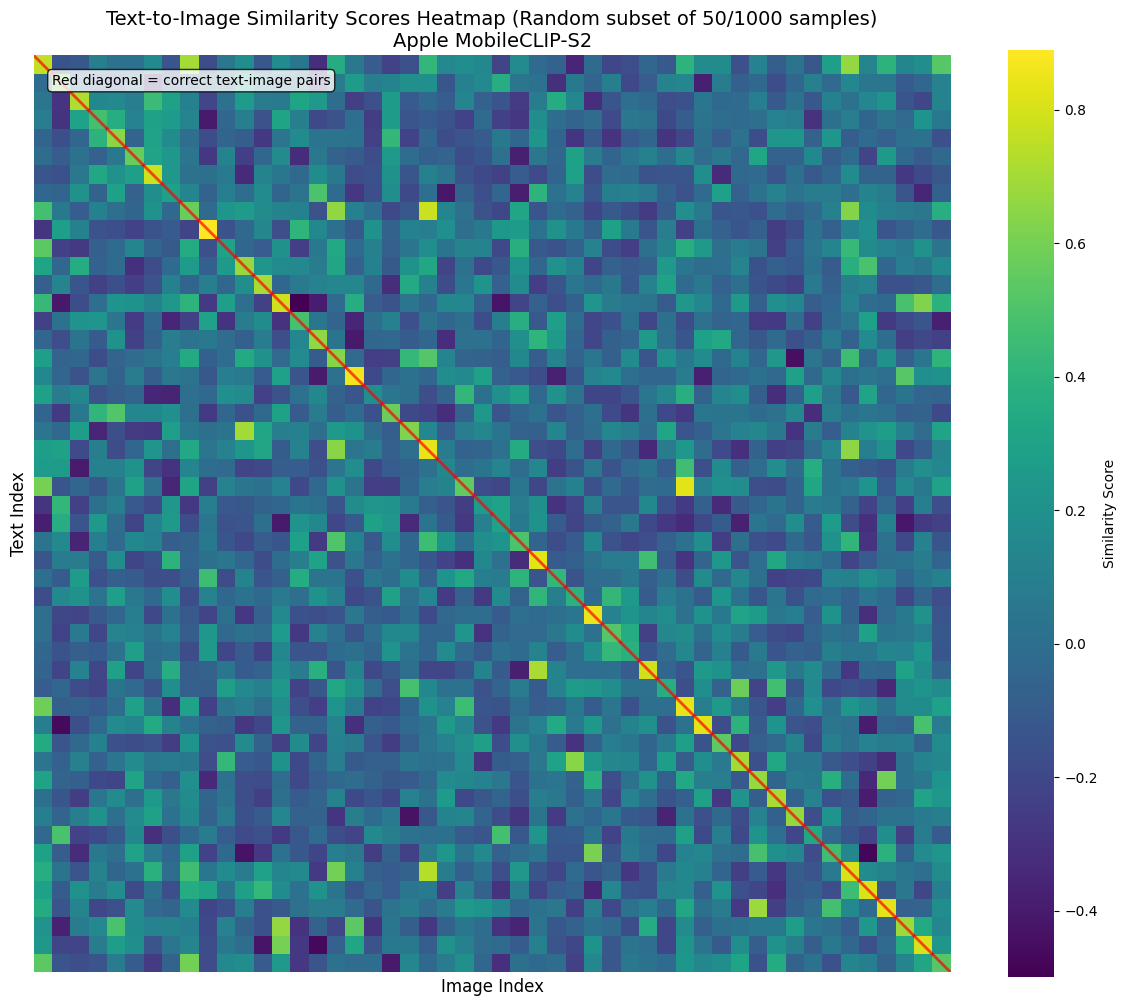

Heatmap shows similarity scores between 50 text queries and 50 images
Perfect retrieval would show a bright diagonal line (high similarity for correct pairs)
Score range: -0.500 to 0.889
Mean diagonal score: 0.602
Mean off-diagonal score: 0.007


<Figure size 640x480 with 0 Axes>

In [22]:
# Create heatmap visualization of similarity scores
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure plots are displayed inline
%matplotlib inline

# For visualization, we'll use a subset if the matrix is too large
max_samples = 50  # Adjust this number based on your preference
n_samples = min(max_samples, scores.shape[0])

# Sample indices for visualization
if scores.shape[0] > max_samples:
    sample_indices = np.random.choice(scores.shape[0], n_samples, replace=False)
    sample_indices = np.sort(sample_indices)  # Keep them sorted for better visualization
    scores_subset = scores[sample_indices][:, sample_indices]
    title_suffix = f" (Random subset of {n_samples}/{scores.shape[0]} samples)"
else:
    scores_subset = scores
    sample_indices = np.arange(scores.shape[0])
    title_suffix = f" (All {scores.shape[0]} samples)"

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(scores_subset.numpy(), 
            cmap='viridis', 
            cbar_kws={'label': 'Similarity Score'},
            square=True,
            xticklabels=False,  # Don't show individual sample labels
            yticklabels=False)

# Highlight the diagonal (correct pairs)
for i in range(len(scores_subset)):
    plt.plot([i, i+1], [i, i+1], 'r-', linewidth=2, alpha=0.7)

plt.title(f'Text-to-Image Similarity Scores Heatmap{title_suffix}\nApple MobileCLIP-S2', fontsize=14)
plt.xlabel('Image Index', fontsize=12)
plt.ylabel('Text Index', fontsize=12)

# Add text annotation about the diagonal
plt.text(0.02, 0.98, 'Red diagonal = correct text-image pairs', 
         transform=plt.gca().transAxes, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
         verticalalignment='top', fontsize=10)

plt.tight_layout()
plt.show()  # Show plot first
plt.savefig('apple_mobileclip_similarity_heatmap.png', dpi=300, bbox_inches='tight')

print(f"Heatmap shows similarity scores between {n_samples} text queries and {n_samples} images")
print(f"Perfect retrieval would show a bright diagonal line (high similarity for correct pairs)")
print(f"Score range: {scores_subset.min().item():.3f} to {scores_subset.max().item():.3f}")
print(f"Mean diagonal score: {torch.diag(scores_subset).mean().item():.3f}")
print(f"Mean off-diagonal score: {scores_subset[~torch.eye(scores_subset.size(0), dtype=bool)].mean().item():.3f}")

In [ ]:
# Compute retrieval metrics on the training set (both text-to-image and image-to-text)
# WARNING: this computes an N x N similarity matrix and can be memory intensive for large datasets.
TRAIN_CSV = Path('../../data/alpaca_mbj_bandgap_train.csv')
train_df = pd.read_csv(TRAIN_CSV)
train_ds = ImageTextDataset(train_df, tokenizer_s2, preprocess_s2, train=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

train_image_embs = []
train_text_embs = []
with torch.no_grad():
    for batch in train_loader:
        images = batch['image'].to(device)
        text_tokens = batch['text_tokens'].to(device)
        
        img_e, txt_e = model(images, text_tokens)
        train_image_embs.append(img_e.cpu())
        train_text_embs.append(txt_e.cpu())

train_image_embeddings = torch.cat(train_image_embs, dim=0)
train_text_embeddings = torch.cat(train_text_embs, dim=0)
print(f'Computed training embeddings: images {train_image_embeddings.shape}, texts {train_text_embeddings.shape}')

# Compute retrieval metrics using our function
print("\n" + "="*60)
print("TRAINING SET RESULTS:")
print("="*60)
scores_train = compute_retrieval_metrics(train_text_embeddings, train_image_embeddings)
print("="*60)

Computed training embeddings: images torch.Size([5000, 256]), texts torch.Size([5000, 256])

TRAINING SET RESULTS:
=== TEXT-TO-IMAGE RETRIEVAL ===
For each text query, find the correct corresponding image
Text-to-Image Top-1: 0.6302
Text-to-Image Top-5: 0.9378
Text-to-Image Top-10: 0.9776

=== IMAGE-TO-TEXT RETRIEVAL ===
For each image query, find the correct corresponding text
Image-to-Text Top-1: 0.6054
Image-to-Text Top-5: 0.9242
Image-to-Text Top-10: 0.9742


# Embedding Visualization

Let's visualize how well our Apple MobileCLIP model aligns the image and text embeddings in the shared space using t-SNE dimensionality reduction.

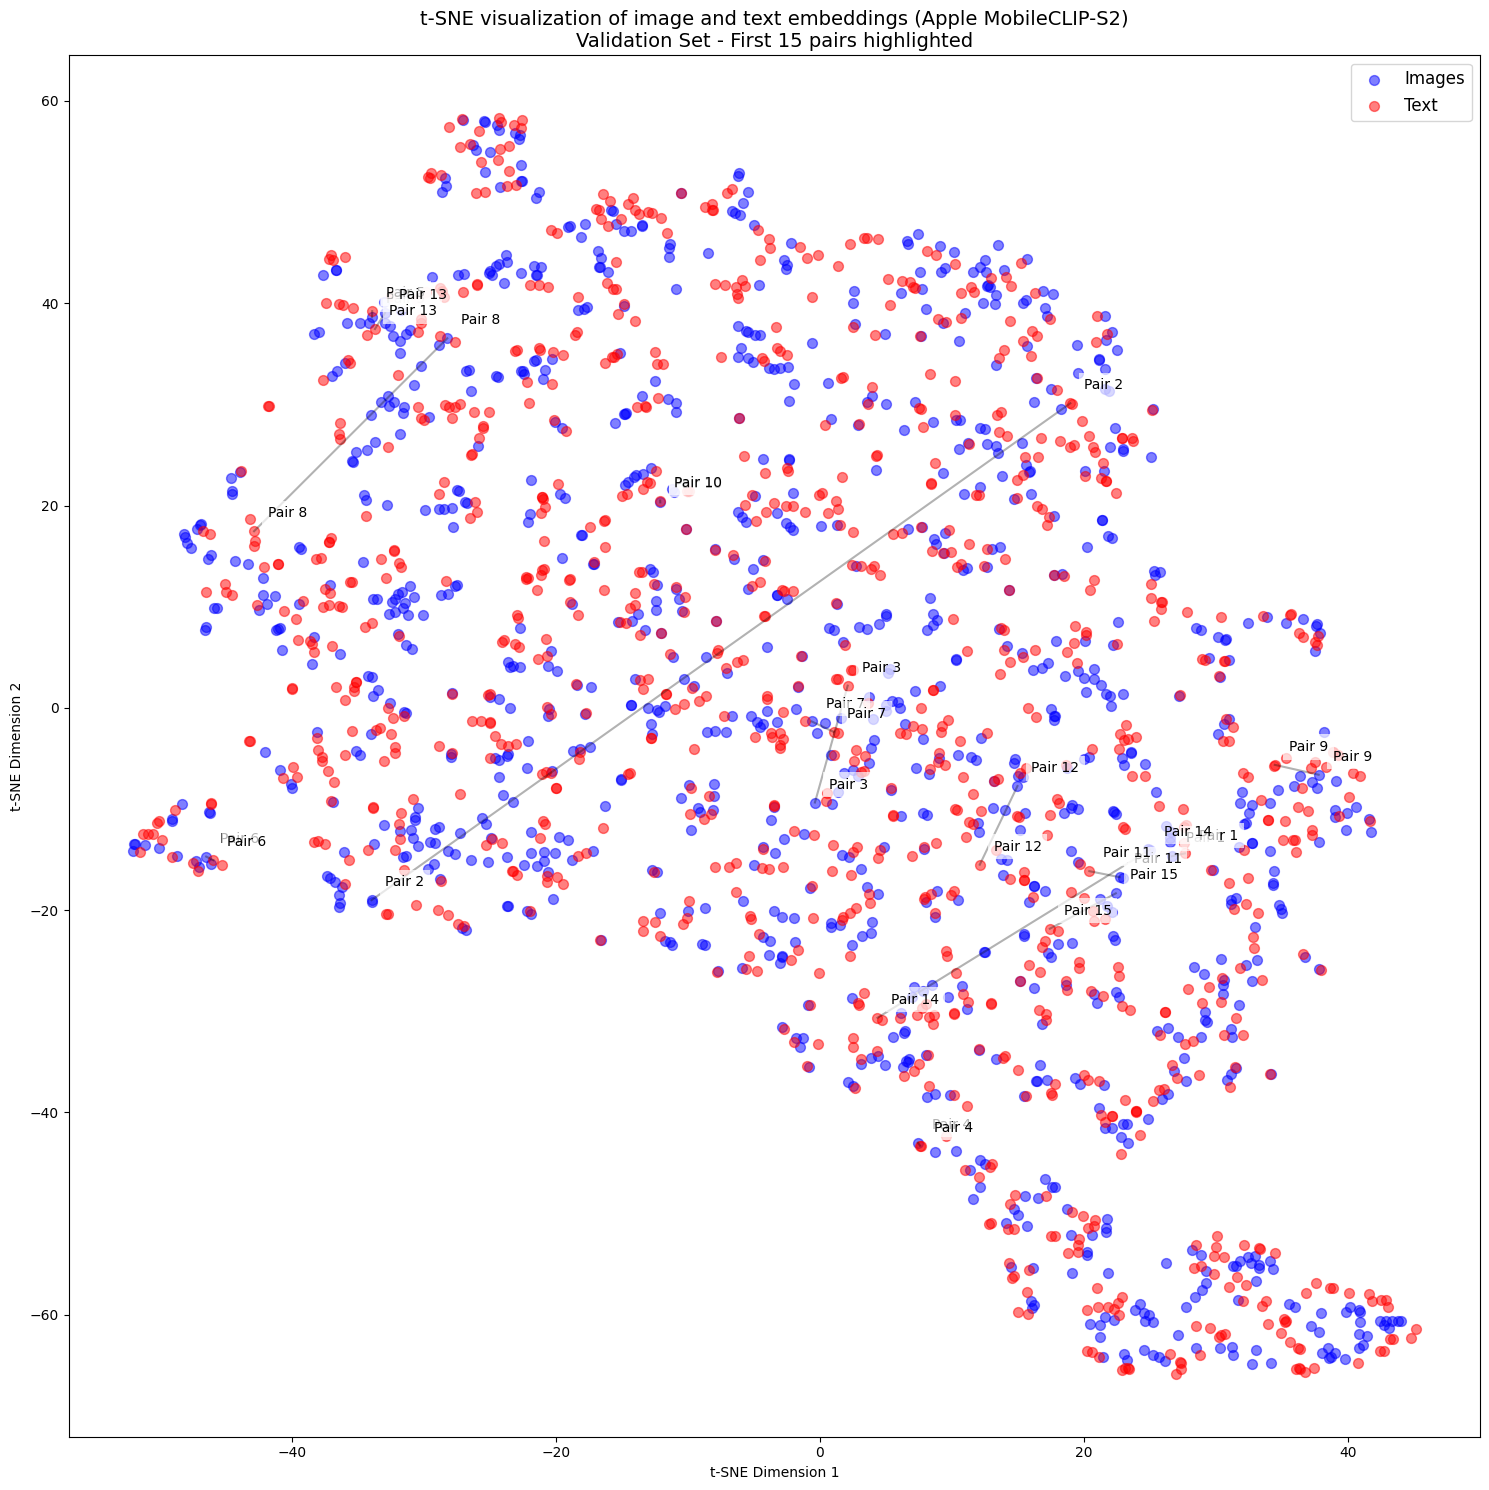

<Figure size 640x480 with 0 Axes>

In [25]:
# t-SNE visualization of embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Ensure plots are displayed inline
%matplotlib inline

# Combine image and text embeddings
combined_embs = torch.cat([val_img_embs, val_txt_embs], dim=0)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
combined_tsne = tsne.fit_transform(combined_embs.numpy())

# Split back into image and text embeddings
n = len(val_img_embs)
img_tsne = combined_tsne[:n]
txt_tsne = combined_tsne[n:]

# Create visualization
plt.figure(figsize=(15, 15))

# Plot all points
plt.scatter(img_tsne[:, 0], img_tsne[:, 1], c='blue', label='Images', alpha=0.5, s=50)
plt.scatter(txt_tsne[:, 0], txt_tsne[:, 1], c='red', label='Text', alpha=0.5, s=50)

# Draw lines connecting corresponding pairs for the first examples
num_examples = 15  # Number of example pairs to highlight
indices = np.arange(min(num_examples, n))  # Use first 15 examples instead of random

for i, idx in enumerate(indices):
    # Draw a line connecting the image-text pair
    plt.plot([img_tsne[idx, 0], txt_tsne[idx, 0]], 
             [img_tsne[idx, 1], txt_tsne[idx, 1]], 
             'k-', alpha=0.3)
    
    # Add number labels
    plt.annotate(f'Pair {i+1}', 
                xy=(img_tsne[idx, 0], img_tsne[idx, 1]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    plt.annotate(f'Pair {i+1}', 
                xy=(txt_tsne[idx, 0], txt_tsne[idx, 1]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.legend(fontsize=12)
plt.title('t-SNE visualization of image and text embeddings (Apple MobileCLIP-S2)\nValidation Set - First 15 pairs highlighted', fontsize=14)
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()  # Show plot first
plt.savefig('apple_mobileclip_tsne.png', dpi=300, bbox_inches='tight')

In [29]:
# text-to-image accuracy
predicted = scores.argmax(dim=1)         # index of the most similar image for each text
correct = torch.arange(len(predicted))   # ground truth (image i should match text i)
accuracy = (predicted == correct).float().mean()
print(f"Text-to-Image Accuracy: {accuracy.item():.4f}")

Text-to-Image Accuracy: 0.3800


# Performance Analysis

Let's analyze the model performance and compare results with other models.

In [32]:
# Show some example retrievals
print("\n=== Example Retrievals ===")

# Get top-5 retrievals for first 5 text queries
num_examples = 5
for i in range(min(num_examples, len(captions))):
    query_text = captions[i]
    similarities = scores[i]
    top5_indices = torch.topk(similarities, 5).indices.tolist()
    
    print(f"\nQuery {i+1}: {query_text}")
    print(f"Top-5 retrieved images (by similarity):")
    for rank, img_idx in enumerate(top5_indices):
        sim_score = similarities[img_idx].item()
        correct = "✓" if img_idx == i else "✗"
        print(f"  Rank {rank+1}: Image {img_idx} Text: {captions[img_idx]} (similarity: {sim_score:.4f}) {correct}")


=== Example Retrievals ===

Query 1: 1 Li 1 Ge 1 S 0.0
Top-5 retrieved images (by similarity):
  Rank 1: Image 0 Text: 1 Li 1 Ge 1 S 0.0 (similarity: 0.6645) ✓
  Rank 2: Image 941 Text: 1 Mg 1 Fe 1 S 0.0 (similarity: 0.6013) ✗
  Rank 3: Image 239 Text: 1 Li 1 Al 1 Ge 0.461 (similarity: 0.5924) ✗
  Rank 4: Image 708 Text: 1 Na 1 Zn 0.0 (similarity: 0.5913) ✗
  Rank 5: Image 888 Text: 1 Zn 1 S 1 O 0.0 (similarity: 0.5906) ✗

Query 2: 1 Pr 1 Te 1 Cl 0.88
Top-5 retrieved images (by similarity):
  Rank 1: Image 376 Text: 1 Sm 1 Ni 0.0 (similarity: 0.6534) ✗
  Rank 2: Image 442 Text: 1 Te 0.615 (similarity: 0.5980) ✗
  Rank 3: Image 270 Text: 1 Nb 2 I 1 O 0.846 (similarity: 0.5851) ✗
  Rank 4: Image 661 Text: 1 K 1 Sn 1 Os 0.377 (similarity: 0.5316) ✗
  Rank 5: Image 265 Text: 1 Te 0.615 (similarity: 0.5307) ✗

Query 3: 1 Fe 4 Sb 12 O 0.0
Top-5 retrieved images (by similarity):
  Rank 1: Image 669 Text: 1 Ba 1 Mg 2 O 5.413 (similarity: 0.6731) ✗
  Rank 2: Image 80 Text: 1 Rb 1 Fe 2 Mo 8 O 0